# All imports

In [76]:
import pandas as pd
import string
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
from pickle import dump, load
from sklearn.cluster import KMeans
from sklearn.feature_selection import chi2 , SelectKBest, mutual_info_regression
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, LassoCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score, make_scorer, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn import tree

# Training K-means cluster model

The aim is to classify US census California regions into 6 clusters based on coordinates and the median household income

Opening data:

In [90]:
X_train=pd.read_csv('/workspaces/Kmeans_housing/data/processed/X_train')
X_test=pd.read_csv('/workspaces/Kmeans_housing/data/processed/X_test')

In [91]:
house_model= KMeans(n_clusters=6, n_init='auto', random_state=42)
house_model.fit(X_train)

KMeans(n_clusters=6, n_init='auto', random_state=42)

In [92]:
y_train=list(house_model.labels_)
X_train['cluster']=y_train
y_test=list(house_model.predict(X_test))
X_test['cluster']=y_test

## Plotting results: train vs test

The light colours of the graphs show the results of the classified median household income for the train data. The predictions of the testing dataset are plotted on top of the trainin results and represented with an 'x' marker. 

Overall, the K-means model seems to perform well classifying the median household income into 6 groups as most of the 'x' markers fall in the coloured dots of the training predictions

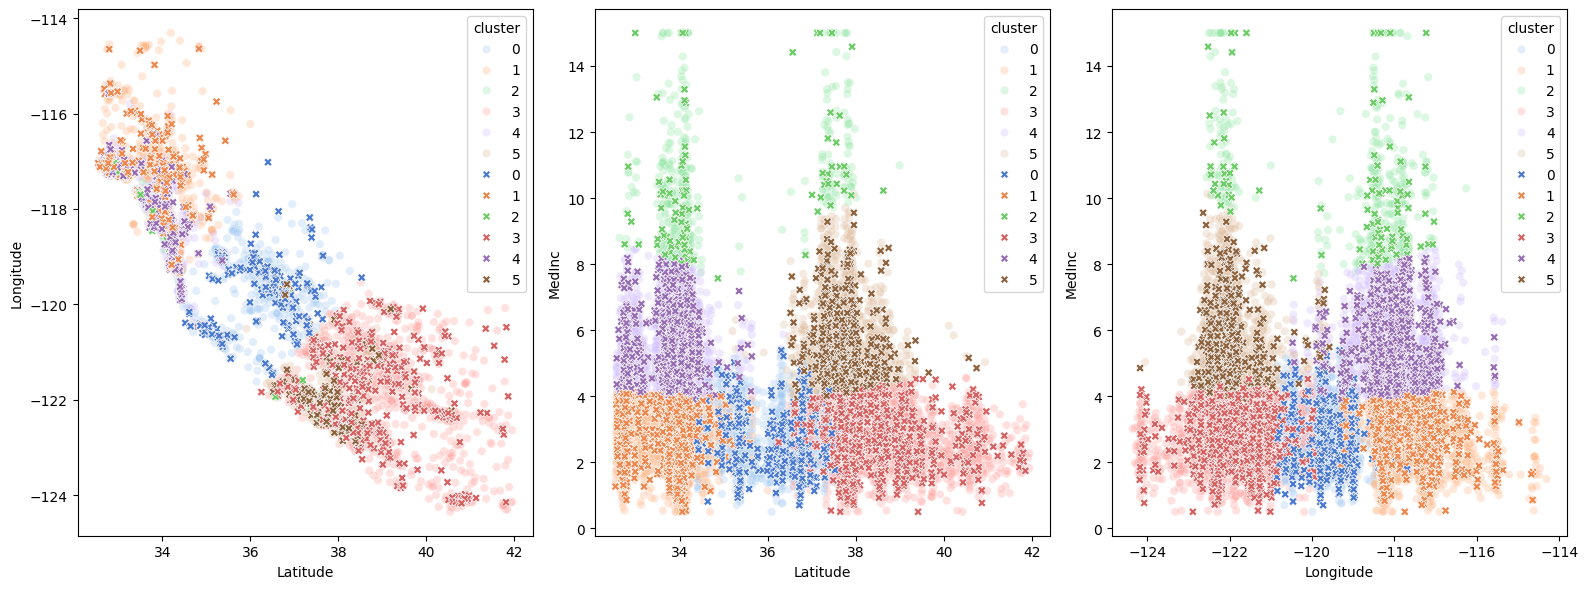

In [93]:
fig, axis = plt.subplots(1, 3, figsize = (16, 6))

sns.scatterplot(X_train, x = "Latitude", y = "Longitude", hue = 'cluster', ax = axis[0], alpha=0.3, palette = "pastel")
sns.scatterplot(X_train, x = "Latitude", y = "MedInc", hue ='cluster', ax = axis[1], alpha=0.3, palette = "pastel")
sns.scatterplot(X_train, x = "Longitude", y = "MedInc", hue ='cluster', ax = axis[2], alpha=0.3, palette = "pastel")

sns.scatterplot(X_test, x = "Latitude", y = "Longitude",hue = 'cluster', marker='X', ax = axis[0], palette = "muted")
sns.scatterplot(X_test, x = "Latitude", y = "MedInc", hue ='cluster', ax = axis[1], marker='X',  palette = "muted")
sns.scatterplot(X_test, x = "Longitude", y = "MedInc", hue ='cluster', ax = axis[2], marker='X', palette = "muted")


plt.tight_layout()

plt.show()

Storing dependent variable

In [94]:
open('/workspaces/Kmeans_housing/data/processed/y_train', "w").write(pd.Series(y_train).to_string(index=False))
open('/workspaces/Kmeans_housing/data/processed/y_train', "w").write(pd.Series(y_test).to_string(index=False))

8253

# Creating supervised model based on Kmeans results

Given that the exploratory data analysis shows non-linear relationships between the key variable and the remaining variables. Linear models will not be considered to estimate the levels of median income.

Random Forest (RF) model will be considered since it has a good balance between accuracy and interpretability, compared to decision tree (prone to overfitting) and boosting (which can be computationally expensive). RF tends to perform well in various scenarios and is less prone to overfitting than a single decision tree.

In [95]:
#Deleting unnecessary variables from train data
X_train.drop(['cluster'], axis=1, inplace=True)
X_test.drop(['cluster'], axis=1, inplace=True)

In [96]:
rf_base=RandomForestClassifier(random_state=42)
rf_base.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [97]:
y_pred_train=rf_base.predict(X_train)
y_pred=rf_base.predict(X_test)

## Model performance

Accuracy train vs test data:

The baseline model suggests the overfitting does not seem concerning since the accuracy of the training data is only one-point difference. The baseline accuracy of the random forest is 99%, which is a good baseline considering this is the baseline model.

In [98]:
rf_acc_base=accuracy_score(y_pred,y_test)
rf_acc_train=accuracy_score(y_pred_train,y_train)
print('Random forest - Accuracy train: ', rf_acc_train)
print('Random forest - Accuracy test: ', rf_acc_base )

Random forest - Accuracy train:  1.0
Random forest - Accuracy test:  0.9944269445117518


**Classification report**

The model performs well on classifying each of the 6 groups since both precision and recall are high

In [99]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       351
           1       1.00      1.00      1.00      1313
           2       0.99      0.98      0.99       103
           3       1.00      0.99      1.00       942
           4       0.99      1.00      0.99       911
           5       0.99      1.00      0.99       507

    accuracy                           0.99      4127
   macro avg       0.99      0.99      0.99      4127
weighted avg       0.99      0.99      0.99      4127



Storing the model

In [100]:
dump(rf_base, open('/workspaces/Kmeans_housing/models/rf_seed42.pk', 'wb'))